In [1]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import math
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

/var/folders/1c/61ndryws2bvfl7r73l3hmwt40000gp/T/ipykernel_1635/1461471607.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Helper Functions

In [2]:
# helper functions 
def scatterplots(stock_list, price_data, abline=False, fig = None, color=None, abline_color = 'r', ylim=None, title=None, twin_ax =False, label=None, ylabel=None):
    if not fig: fig, axs = plt.subplots(3, 2, figsize=(15,7))
    else: (fig, axs) = fig

    for (stock, ax) in zip(stock_list, axs.ravel()):
        if twin_ax: ax = ax.twinx()
        ax.scatter(price_data.time, price_data[stock], s = 1.5, color=color, label=label)
        ax.set_title(stock)
        if label: ax.legend(loc='upper right')
        for month in range(0, 366, 30): ax.axvline(month, color='grey', ls=':', lw=.5, alpha=.5)
        if abline: ax.axhline(price_data[stock].mean(), color=abline_color)
        if ylim: ax.set_ylim((0, ylim))
        ax.set_xlabel('Day')
        if ylabel: ax.set_ylabel(ylabel)
    
    if title: fig.suptitle(title)
    fig.tight_layout()
    return fig, axs

def lineplots(stock_list, price_data, abline=False, fig = None, color=None, abline_color = 'r', ylim=None, title=None,twin_ax =False, label=None, ylabel=None):
    if not fig: fig, axs = plt.subplots(3, 2, figsize=(15,7))
    else: (fig, axs) = fig

    for (stock, ax) in zip(stock_list, axs.ravel()):
        if twin_ax: ax = ax.twinx()
        ax.plot(price_data.time, price_data[stock], color=color, label=label)
        ax.set_title(stock)
        if label: ax.legend(loc='upper right')
        for month in range(0, 366, 30): ax.axvline(month, color='grey', ls=':', lw=.5, alpha=.5)
        if abline: ax.axhline(price_data[stock].mean(), color=abline_color)
        if ylim: ax.set_ylim((0, ylim))
        ax.set_xlabel('Day')
        if ylabel: ax.set_ylabel(ylabel)
        
    if title: fig.suptitle(title)
    fig.tight_layout()
    return fig, axs

In [3]:
# helper functions 
def confint_plots(stocks, time, lower, upper, fig): 
    for stock, ax in zip(stocks, fig[1].ravel()): 
        ax.fill_between(time, lower[stock], upper[stock], color='b', alpha=.1, label='"95%" CI')
        ax.legend(loc='upper right')
    return fig

def lineplots_fitted(stock_list, price_data, abline=False, fig = None, color=None, abline_color = 'r', ylim=None, title=None, twin_ax =False, label=None):
    if not fig: fig, axs = plt.subplots(3, 2, figsize=(15,7))
    else: (fig, axs) = fig

    for (stock, ax) in zip(stock_list, axs.ravel()):
        if twin_ax: ax = ax.twinx()
        stock_data = price_data[stock].dropna()
        ax.plot(stock_data.index, stock_data, color=color, label=label)
        ax.set_title(stock)
        if abline: ax.axhline(price_data[stock].mean(), color=abline_color)
        if ylim: ax.set_ylim((0, ylim))
        ax.legend(loc='upper right')
    
    if title: fig.suptitle(title)
    fig.tight_layout()
    return fig, axs

def dict_to_df(data_dict,to_list=False): 
    max_len = max(len(lst) for lst in data_dict.values())
    if True: data_dict = {k: ([np.nan] * (max_len - len(v))) + list(v) for k, v in data_dict.items()}
    else: data_dict = {k: ([np.nan] * (max_len - len(v))) + v for k, v in data_dict.items()}
    df = pd.DataFrame(data_dict)
    df['time'] = df.index
    return df

def rmse_stock(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def rmse(stocks, y_true, y_pred):
    rmse_stock = {} 
    for stock in stocks: 
        rmse_stock[stock] = np.sqrt(np.mean((y_true[stock] - y_pred[stock])**2))
    return rmse_stock

# Goals of This Exercise
In comparison to the baseline prediction accuracy I computed using a simple moving average model, I want to build a model that has improved 
1. prediction accuracy of the monthly volatility of the individual stock's monthly return.
2. prediction accuracy of the confidence interval of the volatility.

# 1. EDA & Data Preprocessing 

## 1.1 (1) EDA of the Raw Data
First, we explore the data to understand what kind of preprocessing is needed. 
- We check if there is any missing data or outliers.
- We also understand that we are given a price data, so we explore the data to decide how to engineer historical monthly volatility from the given price data while reducing the noise.

We start by checking the summary statistics for each stock and look for indications of missing data or error in the data.

In [4]:
data = pd.read_csv("stockdata3.csv")
days = data.day.unique()
display(data.head(5))
print(f"Stock price data from day {min(days)} to day {max(days)}.")

,day,timestr,a,b,c,d,e,f
0,1,09:30:00,325.450,13.795,94.500,49.985,49.93,17.025
1,1,09:31:00,325.245,13.890,94.515,49.990,49.96,17.025
2,1,09:32:00,325.580,13.905,94.565,49.995,49.96,17.025
3,1,09:33:00,325.470,13.955,94.645,50.065,49.92,17.025
4,1,09:34:00,325.295,13.975,94.580,50.030,49.90,17.025


Stock price data from day 1 to day 362.


In [5]:
describe_df = data.describe().loc[['count', 'mean', 'std', 'min','max']]
na_df = data.isna().sum().to_frame().T.drop(columns=['timestr']).rename(index={0: 'missing row count'})
describe_df = pd.concat([describe_df, na_df])
describe_df

,day,a,b,c,d,e,f
count,98352.00000,98281.000000,98352.000000,98321.000000,98334.000000,98352.000000,96981.000000
mean,181.29732,363.767737,10.048836,69.445570,49.803747,47.727738,13.204838
std,104.61705,28.281333,3.332643,28.675762,4.539923,7.053875,2.404705
min,1.00000,0.000000,4.885000,33.807000,1.000000,38.550000,9.365000
max,362.00000,426.560000,15.335000,116.385000,62.137000,69.210000,18.815000
missing row count,0.00000,71.000000,0.000000,31.000000,18.000000,0.000000,1371.000000


From above, we notice that 
- The data provided does not have a unique time index assigned to each time of the day of the year for comparisons (e.g. there is 'day' column uniform to all stocks traded from day 1 9:30 to 16:00).
- There are six stocks with varying degrees of standard deviation.
- Stocks 'a' and 'd' have a relatively wider price range of [0, 363] and [1, 49] than other stocks, suggesting a possible error in data collection.
- Stocks 'a', 'c', 'd', and 'f', have missing values, indicating that the price of these stocks were not recorded at a  certain time of the day. 

These issues should be taken into account when preprocessing the price data. 

## 1.1 (2) Data Preprocessing
To provide a unique time index for each row, we first confirm that there are no stocks traded on weekends or outside market hours

In [6]:
stocks = 'a b c d e f'.split()
days = data.day.unique()

In [7]:
# check if any stocks were traded outside market hours & weekdays
day_count = defaultdict(int)
for day in days:
    mod_seven = day % 7 
    day_count[mod_seven] += 1 
print(f"days traded: {day_count}")

minute_length = defaultdict(int)
open, close = defaultdict(int), defaultdict(int)
for day in days: 
    day_data = data[data.day == day].timestr
    minute_length[len(day_data)] += 1 
    open[day_data.iloc[0]] += 1
    close[day_data.iloc[-1]] += 1
print(f"the count of minutes traded each day: {minute_length}")
print(f"the count of opening time for each stock: {open}")
print(f"the count of closing time for each stock: {close}")


days traded: defaultdict(<class 'int'>, {1: 46, 2: 52, 3: 52, 4: 51, 5: 51})
the count of minutes traded each day: defaultdict(<class 'int'>, {391: 251, 211: 1})
the count of opening time for each stock: defaultdict(<class 'int'>, {'09:30:00': 252})
the count of closing time for each stock: defaultdict(<class 'int'>, {'16:00:00': 251, '13:00:00': 1})


Since no trades were made during the weekend or outside market hours, we create a "time" index for each row by representing the time of price recorded as a fraction of the day within the market hours. 

In [8]:
data['time']= data.timestr.str.split(":")
data['time'] = data.day + data.time.apply(lambda x: (int(x[0])*60 + int(x[1]) - 570)/390)
data.head()

,day,timestr,a,b,c,d,e,f,time
0,1,09:30:00,325.450,13.795,94.500,49.985,49.93,17.025,1.000000
1,1,09:31:00,325.245,13.890,94.515,49.990,49.96,17.025,1.002564
2,1,09:32:00,325.580,13.905,94.565,49.995,49.96,17.025,1.005128
3,1,09:33:00,325.470,13.955,94.645,50.065,49.92,17.025,1.007692
4,1,09:34:00,325.295,13.975,94.580,50.030,49.90,17.025,1.010256


To address the missing data and possible error in the data, we plot the data and check if the wide range of price for stock 'a' and 'd' is due to an error or if it represents a price fluctuation in the market. 

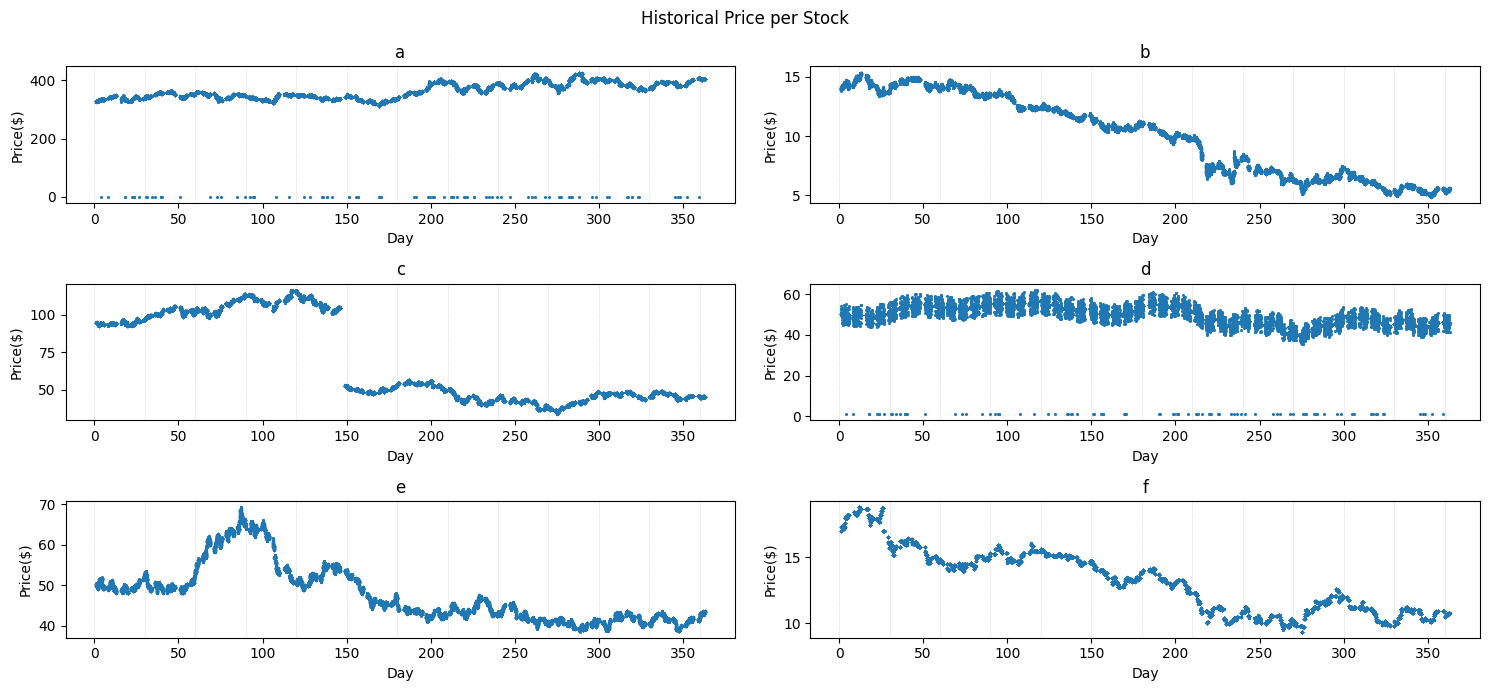

In [9]:
fig_1 = scatterplots(stocks, data, title = 'Historical Price per Stock', ylabel='Price($)')

Notice that 
- For stock a and d with minimum price 0 and 1, the overall price trend over time is consistent other than the minimum values scattered around 0 and 1. This indicates that the minimum value 0 and 1 were an error arose during data collection. 
- For other stocks, we do not see any indicators that the missing values may have significant contribution to the general price trend over time as all stock prices display consistent and gradual stock price movements over short periods. 

Hence, we conclude that 
1. For minimum values (0 and 1) for stock a and d, we replace them with previous price value.
2. For missing values, we forward fill. 

Note that we will discuss the price trend for individual stock in detail in EDA of this notebook. 

,day,a,b,c,d,e,f,time
count,98352.00000,98188.000000,98352.000000,98321.000000,98241.000000,98352.000000,96981.000000,98352.000000
mean,181.29732,364.112284,10.048836,69.445570,49.849947,47.727738,13.204838,181.796825
std,104.61705,25.983384,3.332643,28.675762,4.286434,7.053875,2.404705,104.616761
min,1.00000,311.400000,4.885000,33.807000,35.588000,38.550000,9.365000,1.000000
max,362.00000,426.560000,15.335000,116.385000,62.137000,69.210000,18.815000,363.000000
missing row count,0.00000,164.000000,0.000000,31.000000,111.000000,0.000000,1371.000000,0.000000


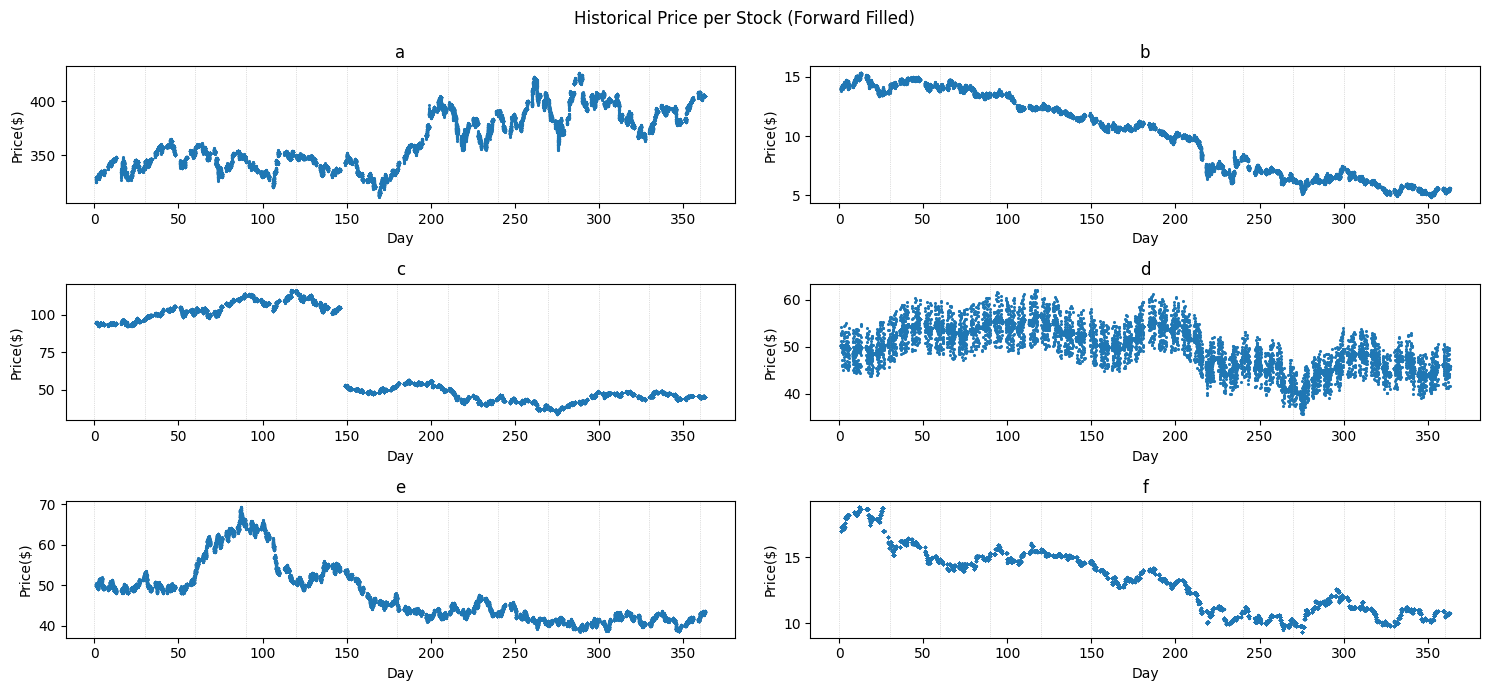

In [10]:
ffilled_data = data.copy() 
for stock in stocks:
    stock_data = ffilled_data[stock]
    ffilled_data[stock] = np.where(stock_data > 1, stock_data, np.nan)

describe_df = ffilled_data.describe().loc[['count', 'mean', 'std', 'min','max']]
na_df = ffilled_data.isna().sum().to_frame().T.drop(columns=['timestr']).rename(index={0: 'missing row count'})
describe_df = pd.concat([describe_df, na_df])
display(describe_df)
fig_2 = scatterplots(stocks, ffilled_data, title='Historical Price per Stock (Forward Filled)', ylabel='Price($)')

Once we forward fill the data, notice that the minimum values of stock A and stock D are now reasonably close to their respective neighboring data points, reflecting a more consistent and coherent price trajectory across the timeline. Also, from the summary statistics, notice that there are no missing values. 



## 1.2 Computing Percentage Return & Monthly Volatility 
Now, we compute the monthly percentage return and monthly volatility of the monthly percentage return. 

**Definitions** 
- We define **monthly percentage return** on time $t$ as $$\frac{price_{t+30} - price_{t}}{price_t}* 100.$$ 
- We define **monthly volatility** as standard deviation of the monthly percentage return as volatility to measure the degree of dispersion of percentage return. 

### Choosing Sampling Frequency to compute Monthly Volatility
To smoothen the data, we consider sampling daily price from the raw price data to remove any noise in the data. To choose which price to represent the daily price of each stock, we explore if the trend of monthly stock return varies for different choice of price. We use the following five prices: 
- daily close price,
- daily open price,
- daily average price,
- daily minimum price,
- daily maximum price.

In [11]:
# compute monthly returns 
open_price = ffilled_data[ffilled_data.timestr == "09:30:00"]
open_price.set_index('day', inplace=True)
close_price = ffilled_data[ffilled_data.timestr == "16:00:00"]
close_price.set_index('day', inplace=True)
average_MthR, highest_MthR, lowest_MthR = pd.DataFrame(columns= stocks), pd.DataFrame(columns= stocks), pd.DataFrame(columns= stocks)
for stock in stocks: 
    stock_daily = ffilled_data.groupby('day')[stock]
    average_price, highest_price, lowest_price = stock_daily.mean(), stock_daily.max(), stock_daily.min()
    average_MthR[stock] = average_price.pct_change(21) * 100
    highest_MthR[stock] = highest_price.pct_change(21) * 100
    lowest_MthR[stock] = lowest_price.pct_change(21) * 100

average_MthR['time'] = average_price.index
average_MthR=average_MthR.dropna()
highest_MthR['time'] = highest_price.index
highest_MthR=highest_MthR.dropna()
lowest_MthR['time'] = lowest_price.index
lowest_MthR=lowest_MthR.dropna()

open_MthR = open_price[stocks].pct_change(21) * 100
open_MthR=open_MthR.dropna()
close_MthR = close_price[stocks].pct_change(21) * 100
close_MthR=close_MthR.dropna()

/var/folders/1c/61ndryws2bvfl7r73l3hmwt40000gp/T/ipykernel_1635/620444342.py:21: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  open_MthR = open_price[stocks].pct_change(21) * 100
/var/folders/1c/61ndryws2bvfl7r73l3hmwt40000gp/T/ipykernel_1635/620444342.py:23: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  close_MthR = close_price[stocks].pct_change(21) * 100


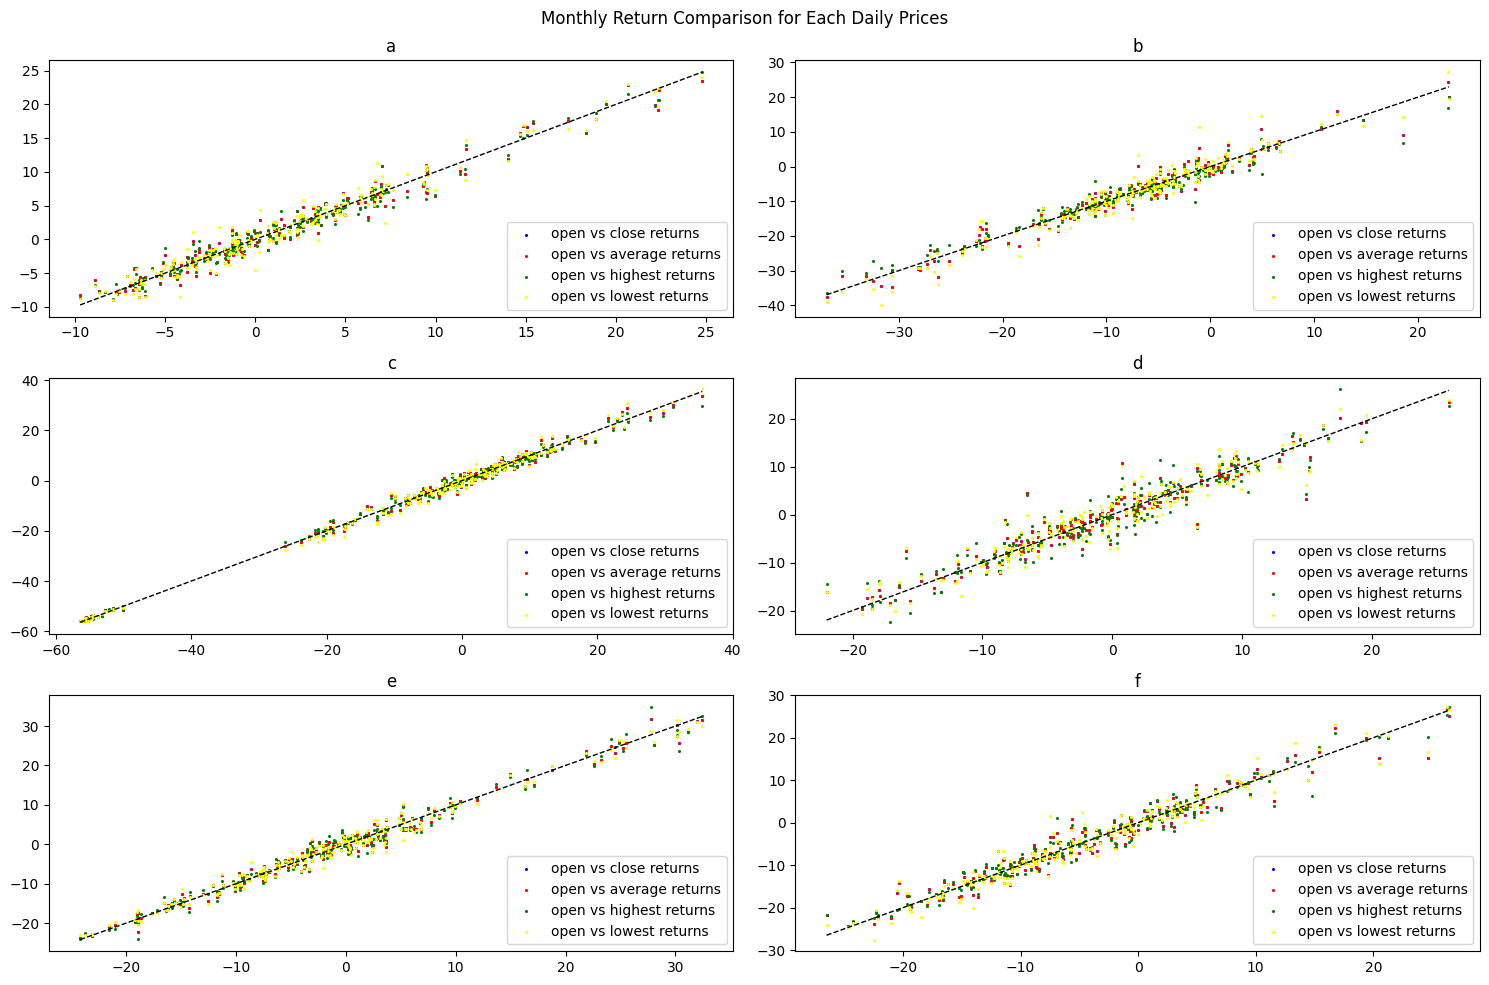

In [12]:
# compare the monthly return trend
fig, axs = plt.subplots(3, 2, figsize=(15,10))
for (stock, ax) in zip(stocks, axs.ravel()):
    ax.scatter(open_MthR[stock].iloc[:-1], average_MthR[stock].iloc[:-1], s = 1.5, color='b', label='open vs close returns')
    ax.scatter(open_MthR[stock].iloc[:-1], average_MthR[stock].iloc[:-1], s = 1.5, color='r', label='open vs average returns')
    ax.scatter(open_MthR[stock], highest_MthR[stock], s = 1.5, color='g', label='open vs highest returns')
    ax.scatter(open_MthR[stock], lowest_MthR[stock], s = 1.5, color='yellow', label='open vs lowest returns')
    # plot y = x based on the range of the data
    min_val, max_val = open_MthR[stock].min(), open_MthR[stock].max()
    ax.plot(np.linspace(min_val, max_val, 100), np.linspace(min_val, max_val, 100), color='black', ls='--', lw=1)
    ax.set_title(stock)
    ax.legend(loc="lower right")
fig.suptitle('Monthly Return Comparison for Each Daily Prices')
fig.tight_layout()

From the linear relationship between monthly returns calculated based on daily open, closed, average, highest, lowest price, we claim that the trend of monthly return does not change based on the choice of daily price.  Then, we decide to use open price to compute monthly volatility for each stock. 

## 1.3 EDA on Monthly Volatility

Now, we compute monthly volatility using a 22 day rolling window on the monthly return based on daily open price for each stock. 

In [13]:
monthly_return = open_price.copy()
for stock in stocks: 
    monthly_return[stock] = monthly_return[stock].pct_change(22)*100 
# monthly_return['time'] = open_price.time

monthly_vol = monthly_return.copy()
days = monthly_return.index
for stock in stocks: 
    for day in days: 
        if day > 30: 
            lookback = day - 30 
            if lookback not in days: 
                # can be missing if it's a holiday or weekend 
                # replace lookback with closest day before lookback
                lookback = days[days>lookback][0]
            monthly_vol.loc[day, stock] = monthly_return[stock].loc[lookback:day].std() 
        else: 
            monthly_vol.loc[day, stock] = np.nan
                
monthly_vol=monthly_vol.dropna()

/var/folders/1c/61ndryws2bvfl7r73l3hmwt40000gp/T/ipykernel_1635/255499179.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_return[stock] = monthly_return[stock].pct_change(22)*100


/var/folders/1c/61ndryws2bvfl7r73l3hmwt40000gp/T/ipykernel_1635/777527600.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_3[0].show()


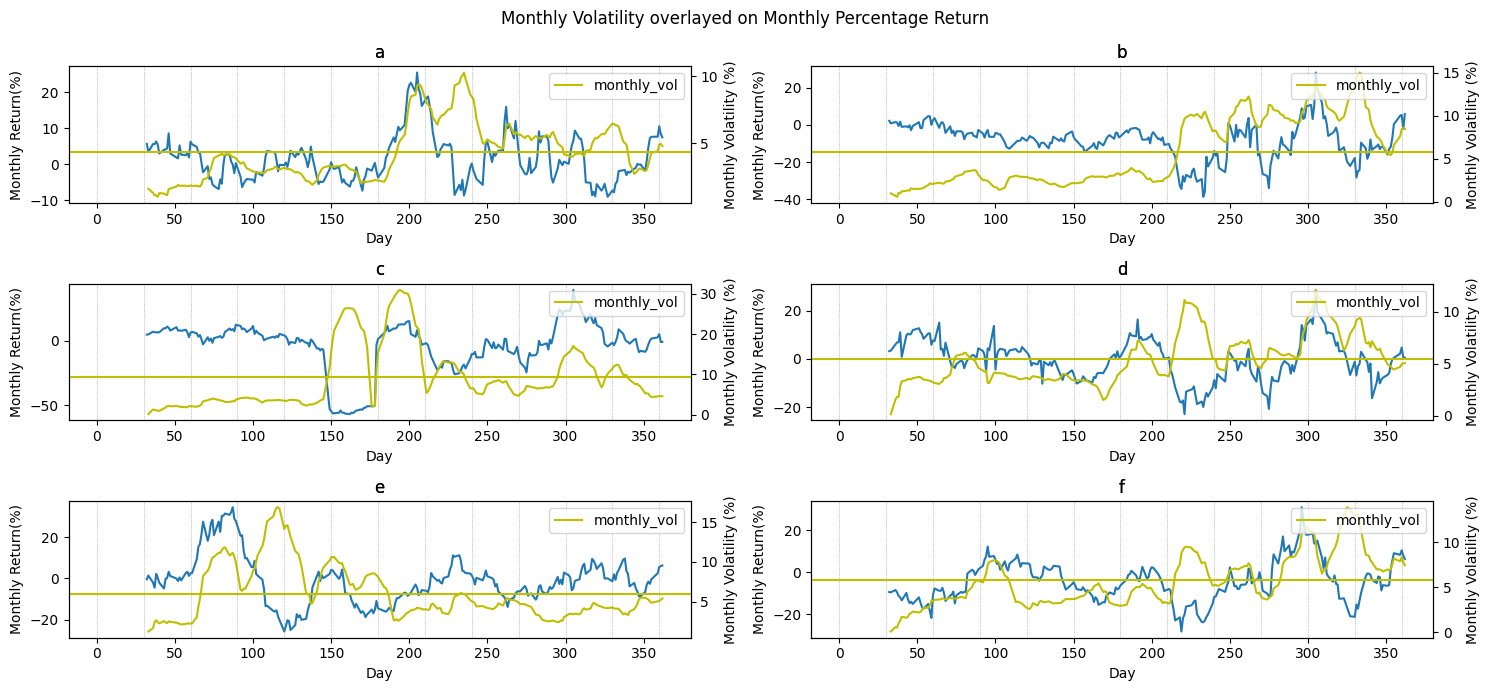

In [14]:
fig_3 = lineplots(stocks, monthly_return, title='Monthly Volatility overlayed on Monthly Percentage Return', ylabel='Monthly Return(%)')
fig_3 = lineplots(stocks, monthly_vol, twin_ax=True, fig=fig_3, color='y', abline=True, abline_color='y', label='monthly_vol', ylabel='Monthly Volatility (%)')
fig_3[0].show() 

From above plots, we observe that 
1. There is a nonzero and heterogenous monthly volatility for all returns. 
2. There is a sharp volatility spike for stock a (day 200), c (day 150), and e(day 100), which was preceded by a sharp change in return.
3. There is an increase of volatility for stock a, b, d and f over time.
4. The volatility moves in a consistent and gradual pattern, i.e. the frequency of fluctuations is spanned over at least a couple weeks.

This is also confirmed by the volatility comparison plot below, as we observe c and e with a significant change in return exhibit higher volatility than other stocks.

/var/folders/1c/61ndryws2bvfl7r73l3hmwt40000gp/T/ipykernel_1635/2338818591.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


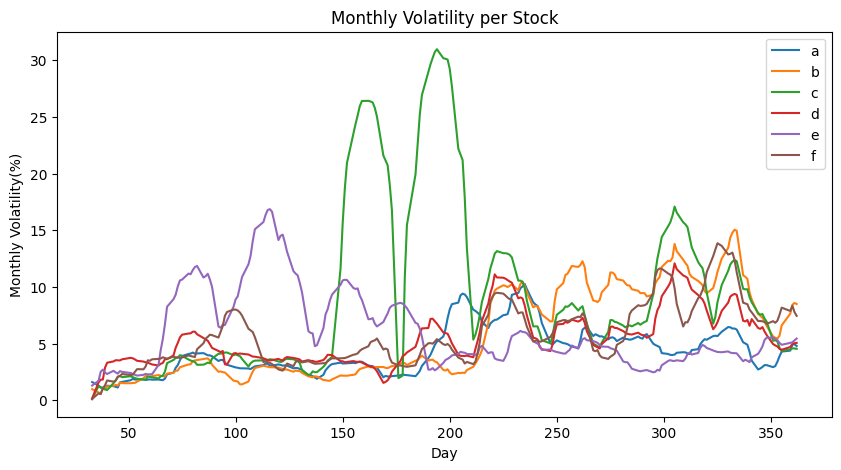

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
for stock in stocks:
    ax.plot(monthly_vol[stock], label=stock)
    ax.legend()

# set y and x axis labels
ax.set_xlabel('Day')
ax.set_ylabel('Monthly Volatility(%)')
ax.title.set_text('Monthly Volatility per Stock')
fig.show()

# 2. Volatility Modelling 

## 2.1 Deciding the Input of the Model

We first decide what the input of the model should be. A paper $[1]$ suggests that past volatility is persistent in short terms, indicating that using short term past volatility data can be useful in predicting future near-term volatility. Then, we want to decide up to what days should the model take into account per each stock. We use autocorrelation value of volatility at day $t$ and day $t-k$, $$ \frac{\sum_{t=k+1}^{362} (MV_{t} - \bar{MV}) (MV_{t-k} - \bar{MV})}{\sum_{t=k+1}^{362} (MV_{t} - \bar{MV})^2} = \frac{\text{Covariance} (MV_{t}, MV_{t-k})}{\text{Variance}(MV_t)}.$$ Then, the autocorrelation value can be thought of as covariance of volatility at day $t$ and day $t-k$ not explained by the variance of volatility for each day.

We compute autocorrelation upto lag(or weekday) 44 (approximately 2 months) and consider all lags whose autocorrelation value has p value less than 0.05. 

---------------
$[1]$ Dreyer, A., & Hubrich, S. (2017). Tail risk mitigation with managed volatility strategies. Dreyer, Anna and Hubrich, Stefan, Tail Risk Mitigation with Managed Volatility Strategies (April 16, 2019). Journal of Investment Strategies, 8(1), 29-56.

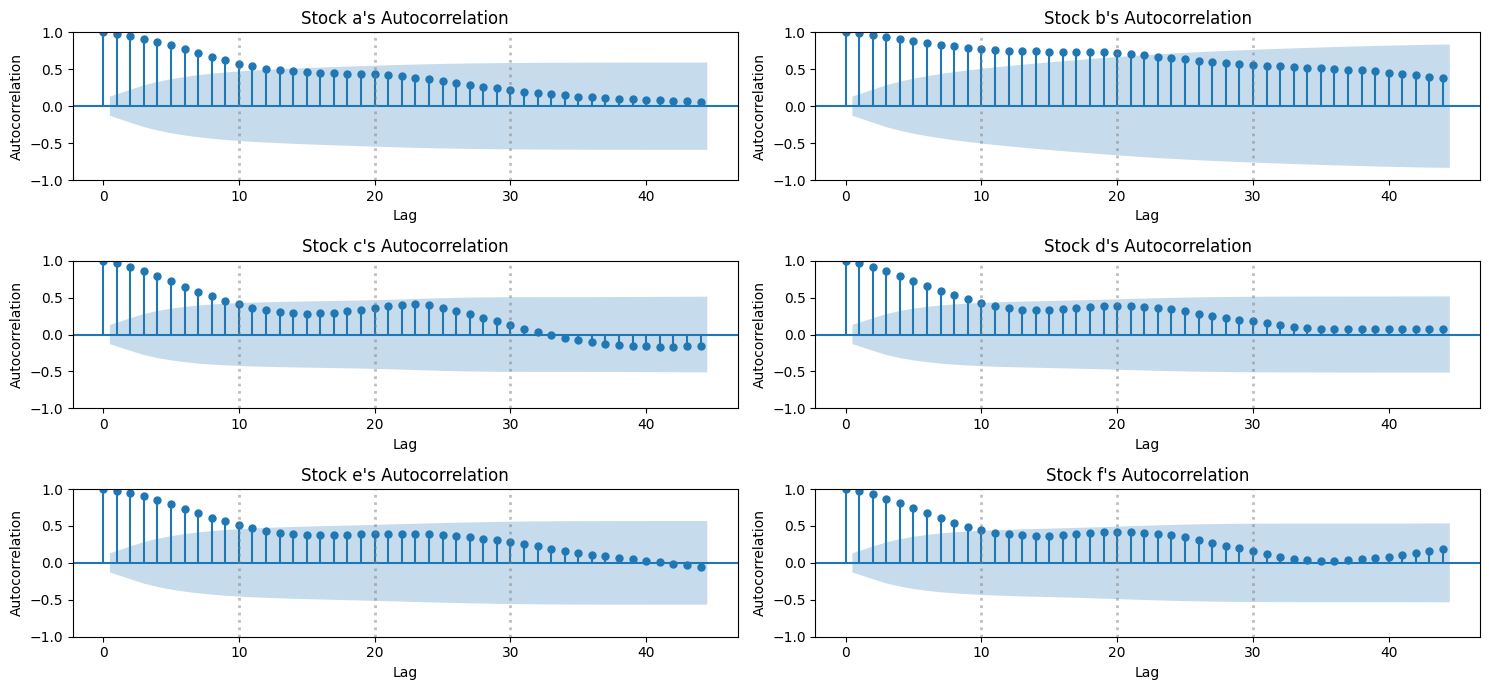

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(15,7))
for stock, ax in zip(stocks, axs.ravel()):
    sm.graphics.tsa.plot_acf(monthly_vol[stock], ax=ax, lags=44, title=f"Stock {stock}'s Autocorrelation")
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    for day in range(10, 40, 10): ax.axvline(day, color='grey', ls=':', lw=2, alpha=.5)
fig.tight_layout()

Notice from above acf plots that 
1. the length of significant lags varies for each stock and must be taken into account by implementing different lookback values.
2. there are several significant lags from the autocorrelation value higher than the confidence interval (blue shaded area), indicating that previous days' volatility data offers some level of indication to the future volatility price. 

We decide the lookback for each stock based on the highest lag whose autocorrelation value is higher than the confidence interval: 
$$acf = \{a:11, b:21, c:10, d: 9, e:11, f:11\}$$

Furthermore, to explore the relationship between previous days' volatility data and future volatility price, we plot the autocorrelations of the first 17 days. 

Text(0.5, 1.0, 'ACF of Monthly Volatility per Stock')

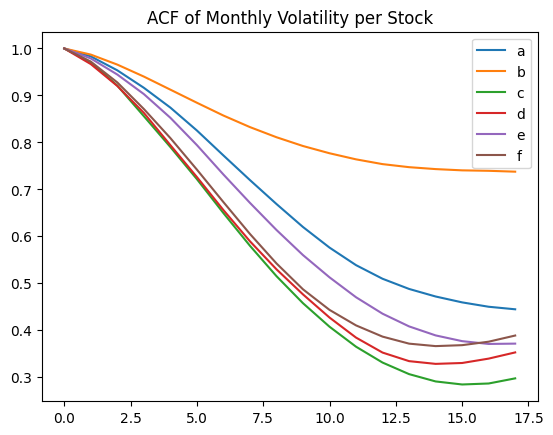

In [17]:
stock_acf = {'a':11, 'b':21, 'c':10, 'd': 9, 'e':11, 'f':11}
for stock in stocks: 
    acfs = [] 
    acfs = sm.tsa.acf(monthly_vol[stock], nlags=17, fft=False)
    plt.plot(acfs, label=stock)
plt.legend(loc='upper right')
plt.title('ACF of Monthly Volatility per Stock')

From above plot, we observe that there is a decaying trend of ACF as lag increases. Hence, we conclude that the prediction model should be based on some exponential function to combine the previous days' volatility data and also account for the exponential decay of autocorrelations over time.


## 2-2. Volatility Modelling (1): Baseline EWMA Model

For day $t$, I use monthly volatility data from day $t-lookback-1$ to day $t-1$ to predict the value for day $t$. Based on the exponential decay of autocorrelation values, we assign exponential weights to the past data and build an exponential weighted moving average model (EWMA). The model predicts volatility of day $t$, $\hat{MV}_t$ by taking in
- Input:
    - Exponential decay rate $\alpha$.
    - Length of lookback ($L$) = highest lag whose autocorrelation is outside the confidence interval.
    - Previous days' volatility data within the length of lookback from the previous day of prediction.
- Algorithm: 
    - To address the large jumps in the volatility, we incorporate a simple exponential weighted moving average model suggested by this paper $[2]$: $$\hat{MV}_t = \frac{\sum_{i=1}^L \alpha^i \cdot MV_{t-i}}{\sum_{i=1}^L \alpha^{i}}$$ 
    - Note that
        - This algorithm bases calculation on an undecided parameter $\alpha$.
        - This algorithm assigns exponentially higher weights to volatility from closer dates.
        - The prediction can only start on day $t > L$.
        - Referring to a paper $[2]$ that suggests alpha = 0.03, we use the initial alpha vlaue as 0.03 to prioritize exploring the model.

- Score Equation: 
    - Since we value the accuracy of the volatility prediction as well as the 1 stdev confidence interval, we decide to use following score equations for each for model comparisons. 
    - For the volatility prediction, we use Root Mean Squared Error (RMSE) to see the overall size of error for all predictions for each stock: $$\sqrt{\frac{\sum_{t = t_0}^{t_1}(MV_t - \hat{MV_{t}})^2}{t_1 - t_0}} $$.
    - For the confidence interval ($C(t)$), we use the coverage rate: For a confidence interval on date $t$ from date $t_0$ to $t_1$, $$\frac{\sum_{t = t_0}^{t_1}(\mathbb{1}_{MV_t \in C(t)})}{t_1 - t_0} * 100 % $$.

---------------
$[2]$ Bernard Bollen (2015) "What should the value of lambda be in the exponentially weighted moving average volatility model?", Applied Economics, 47:8, 853-860, DOI: 10.1080/00036846.2014.982853 (https://www.une.edu.au/__data/assets/pdf_file/0009/76464/unebsop14-1.pdf)

In [52]:
def compute_ewma(data, alpha, lookback):
    # note: does not include mv_t in the prediction of mv_t
    numerator, denominator = 0, 0
    for i in range(lookback): 
        numerator += alpha ** (i+1) * data[lookback-1-i] 
        denominator += alpha ** (i+1)
    return numerator / denominator

def ewma_timeseries(stock, data, alpha, lookback):
    vol_data = data[stock].values  # took .values as the days are not constant, jumps on the weekends 
    ewma_values = []
    for t in range(lookback+1, len(vol_data)):
        value = compute_ewma(vol_data[t-lookback-1 : t-1], alpha=alpha, lookback=lookback)
        ewma_values.append(value)
    ewma_values = pd.DataFrame(ewma_values, columns=[stock])
    ewma_values= ewma_values.set_index(monthly_vol.index[lookback+1:])
    ewma_values.index+= 1 
    return ewma_values 

def compute_ewma_stocks(stock_list, data, stock_acf, alpha=0.03): 
    ewma_fits = pd.DataFrame()
    for stock in stock_list: 
        lookback = stock_acf[stock]
        ewma_stock = ewma_timeseries(stock, data, alpha, lookback)
        ewma_fits[stock] = ewma_stock
    ewma_fits['time'] = ewma_fits.index
    rmse_per_stock = rmse(stocks, monthly_vol, ewma_fits)
    sigma = ewma_fits.rolling(20).std()
    confint = pd.concat([ewma_fits - sigma, ewma_fits + sigma], axis=1, keys=['lower', 'upper'])
    
    return ewma_fits, rmse_per_stock, confint

In [53]:
alpha = 0.03
ewma_fits, rmse_base, confint = compute_ewma_stocks(stocks, monthly_vol, stock_acf, alpha)
sigma = ewma_fits.rolling(20).std()

# compute how well confint is capturing the actual volatility
base_coverage = {}
# print(f"predictions:")
for stock in stocks: 
    coverage =np.mean((monthly_vol[stock] - confint.lower[stock]) * (confint.upper[stock] - monthly_vol[stock]) > 0) * 100
    base_coverage[stock] = coverage
    print(f"stock {stock}'s RMSE {rmse_base[stock]}, confidence interval coverage {np.round(base_coverage[stock], 2)}%")
# display(monthly_vol.tail(5).T)

stock a's RMSE 0.7702484986437987, confidence interval coverage 41.45%
stock b's RMSE 1.2055691714405659, confidence interval coverage 36.36%
stock c's RMSE 3.725109278959404, confidence interval coverage 43.64%
stock d's RMSE 1.0855813866315114, confidence interval coverage 38.55%
stock e's RMSE 1.3616099645670416, confidence interval coverage 42.91%
stock f's RMSE 1.1893010001307915, confidence interval coverage 38.55%


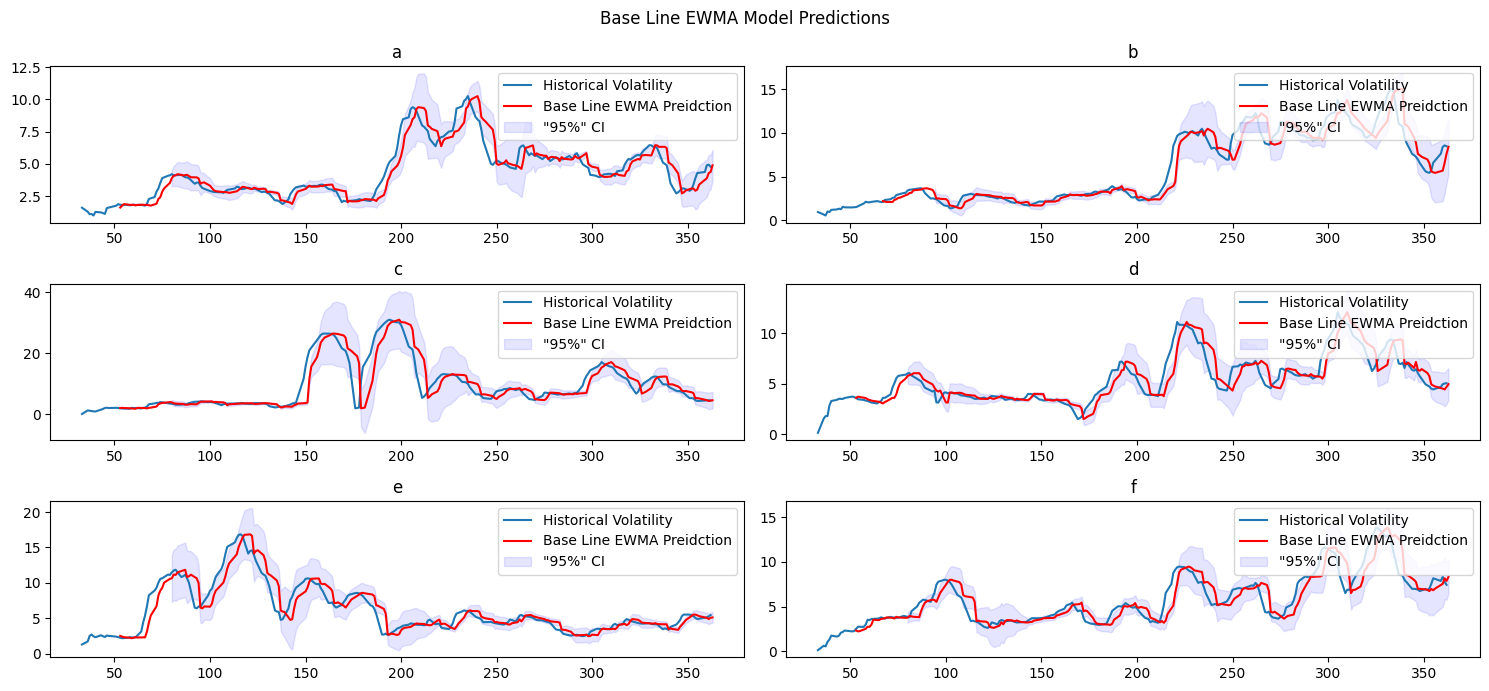

In [42]:
fig_ewma = lineplots_fitted(stocks, monthly_vol, title='Historical Price', label='Historical Volatility')
fig_ewma = lineplots_fitted(stocks, ewma_fits, fig=fig_ewma, title='Base Line EWMA Model Predictions', color='red', label='Base Line EWMA Preidction')
fig_ewma = confint_plots(stocks, confint.index, confint.lower, confint.upper, fig_ewma)


From above, we observe that 
- The EWMA model predicts the trend of the real historical volatility to some extent as shown by the similarities of the plots of real and predicted volatility.
- However, there exists a significant lag between the prediction and the real volatility. For stock C with high jump, the prediction suffers an exceptionally high RMSE. 

Then, while keeping the general structure of exponential weighting, we aim to reduce the lag by dynamically adjust the weights to decrease such lag between the fitted and actual values.

## 2-3. Volatility Modelling (2): Dynamic Weights

Inspired by weighted linear regression's mechanism, to decrease the lag, we want to assign higher weights to more recent & important data based on some feature that can be engineered from the historical data. We notice that one way to do so is coming up with an indicator of a distribution shock (e.g. stock c). Such can be detected by comparing the RMSE of the most recent prediction to the past RMSE values. 

Motivation: 
- If RMSE becomes larger than some confidence interval (within 1 standard deviation) then it means there has been a shift in the recent distribution of data.
- Then, the model needs to adjust the weights of the moving average assigned to $MV_{t-1}, \cdots MV_{t-lookback-1}$, specifically with focus on increasing the weight of $MV_{t-1}$. 

### Change of ACF over Time

If there has been a significan shift in the more recent volatility, we want to assign higher weights to the more recent data. We explore if ACF can be an indicator to the change of importance of more recent data. 

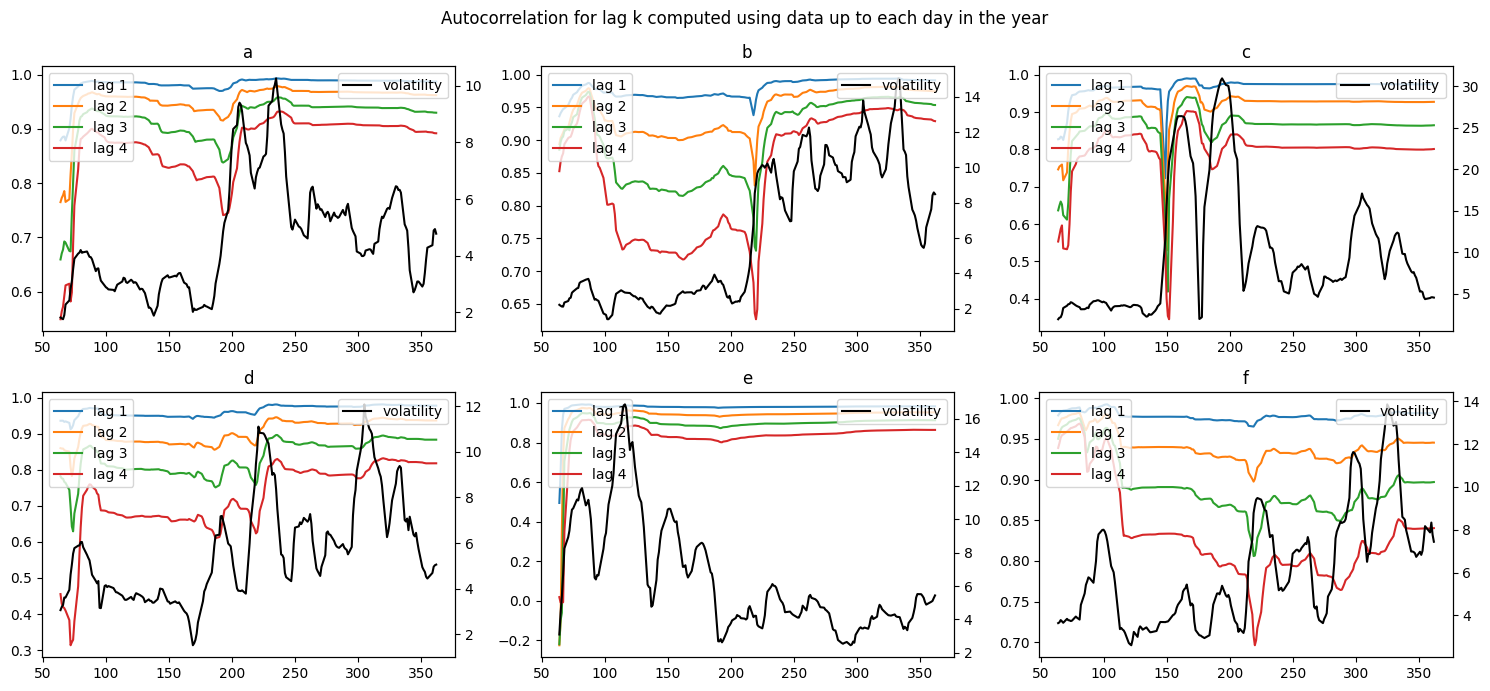

In [21]:
fig, axs = plt.subplots(2,3, figsize=(15,7)) # width, height
for stock, ax in zip(stocks, axs.ravel()):
    for lag in range(1,5): 
        ac_k = []
        # compute lag up to each day from day 20 (month 2) to day 365 and see how it changes 
        # started at month 2 to ensure that we have enough data to compute the lag
        for day in monthly_vol.index[20:]: 
            autocorrelation_k = monthly_vol[stock].loc[:day].autocorr(lag=lag)
            ac_k.append(autocorrelation_k)
        ax.plot(monthly_vol.index[20:], ac_k, label=f'lag {lag}')
    ax.set_title(stock)
    ax.legend(loc='upper left')
    
    # plot volatility
    twinax = ax.twinx()
    twinax.plot( monthly_vol[stock][20:], color='black', label='volatility')
    twinax.legend(loc = 'upper right')

fig.suptitle('Autocorrelation for lag k computed using data up to each day in the year')

fig.tight_layout()

From the above plot, we confirm that 
- Autocorrelation for all lags follow the general trend (drops and jumps) of volatility.
- Autocorrelation for lag k does not change significantly if the volatility is steady. 
- Autocorrelation for lag k highly fluctuates around the "jump"s in volatility. Specifically, the higher the lag is, the higher the autocorrelation value decreases. 

Then, we conclude that autocorrelation can be a useful indicator to the degree of statistical significance of past volatility data. 

### Dynamic Weight Adjusting

Based on the finding, we come up with the following mechanism:

0. Initialize the "weight" for each power of each exponential coefficient as 1.  
1. Compute autocorrelation to detect how much more "significant" the recent values got. 
2. Based on the ratio of autocorrelation, decrease the power of more significant acf by subtracting autocorrelation * step_size from the current power. 

- Note that since alpha < 1, the lower the power of alpha is, the higher weight is imposed to the actual data. Also, this ensures that same weighting mechanism applies for negative powers.
- Furthermore, since the power weights will change over time, influenced by all past historical data, it also takes into account long term memory of the past data while adapting to the recent changes as well.  

For example, suppose the autocorrelation valuel changed for lag 1 to 3 from [.3,.3,.5] to [.1,.2,.7]. Then, the weights of power will change from [1, 1, 1] to [0.999, 0.998, 0.993]. 

In [50]:
def is_OutOfBound(new_rmse, past_rmse_vals, std):
    if new_rmse > np.mean(past_rmse_vals) + 1.96* std or new_rmse < np.mean(past_rmse_vals) - 1.96 * std: 
        return True
    return False

def decide_powers(day, power_weights, past_rmses_within_lookback, lookback):
    if not past_rmses_within_lookback: raise ValueError("mse_record is empty")
    ob_flag = is_OutOfBound(past_rmses_within_lookback[-1], past_rmses_within_lookback, np.std(past_rmses_within_lookback))
     
    if ob_flag: 
        acfs = sm.tsa.acf(monthly_vol[stock][:day], nlags=lookback) 
        power_weights = [power_weight - acf * 0.01 for acf, power_weight in zip(acfs, power_weights)] #  
    return power_weights

def compute_dynamic_ewma(data, alpha, lookback, power_weights):
    # note: does not include mv_t in the prediction of mv_t
    numerator, denominator = 0, 0
    for i in range(lookback): 
        numerator += alpha  ** (power_weights[i] * (i+1)) * data[lookback-1-i] 
        denominator += alpha  ** (power_weights[i] * (i+1))

    return numerator / denominator

def dynamic_ewma_timeseries(stock, data, alpha, lookback, show_time=False):
    day = 0
    stock_data, start_date, last_date = data[stock], data.index[0], data.index[-1]
    vol_data, ewma_preds, power_weights_record, rmse_preds = data[stock].values, {}, {}, []
    
    if show_time: 
        print(f'For stock {stock}, received volatility data in period ({start_date}) - ({last_date})')
        print(f'Using lookback of {lookback} days, computing the first EWMA prediction from day {start_date + lookback + 1} to day {start_date + lookback*2}')
    for day in range(lookback + 1, lookback*2 + 1):
        ewma_pred = compute_ewma(vol_data[day - lookback - 1 : day-1], alpha=alpha, lookback=lookback)
        rmse_pred = (vol_data[day-1] - ewma_pred)**2
        rmse_preds.append(rmse_pred)
        ewma_preds[stock_data.index[day]] = (ewma_pred)
    
    power_weights = [1] * lookback 
    power_weights_record[lookback*2] = power_weights
    if show_time: print(f'Now computing dynamic EWMA predictions from day {start_date + lookback*2 + 1} to day {last_date + 1}')
    for day in range(lookback*2 + 1, len(vol_data)+1): 
        power_weights = decide_powers(day, power_weights, rmse_preds[day-lookback*2 -1 : day-lookback-1], lookback)
        ewma_pred = compute_dynamic_ewma(vol_data[day-lookback-1 : day-1], alpha=alpha, lookback=lookback, power_weights=power_weights)
        if day < len(vol_data): 
            rmse_pred = math.sqrt((vol_data[day-1] - ewma_pred)**2)
            rmse_preds.append(rmse_pred)
            ewma_preds[stock_data.index[day]] = (ewma_pred)
        else: 
            ewma_preds[363] = (ewma_pred)
        power_weights_record[day] = power_weights
        
    return ewma_preds, power_weights_record

def compute_dynamic_ewma_stocks(stock_list, data, stock_acf, alpha=0.06): 
    dynamic_ewma_pred, real_vol, powers_per_stock, rmse_dynamic = pd.DataFrame(), pd.DataFrame(), {}, {}
    for stock in stock_list: 
        lookback = stock_acf[stock]
        ewma_stock, power_weight_stock = dynamic_ewma_timeseries(stock, data, alpha, stock_acf[stock])
        ewma_stock = pd.Series(ewma_stock)
        ewma_stock.index.name = 'time'
        rmse_dynamic_stock = np.sqrt(np.mean((data[stock].loc[ewma_stock.index[:-1]] - ewma_stock.iloc[:-1])**2))
        
        # store computed dynamic ewma predictions, mse, and power weights
        dynamic_ewma_pred[stock] = ewma_stock
        rmse_dynamic[stock] = rmse_dynamic_stock
        powers_per_stock[stock] = dict_to_df(power_weight_stock).drop(columns='time').T

        # store real volatility for comparisons
        real_vol_stock = monthly_vol[stock].loc[lookback*2:]
        real_vol = pd.concat([real_vol, real_vol_stock], axis=1)
        
    dynamic_ewma_pred['time'] = dynamic_ewma_pred.index
    real_vol['time'] = real_vol.index
    return dynamic_ewma_pred, real_vol, powers_per_stock, rmse_dynamic

In [51]:
alpha = 0.03
dynamic_ewma_pred, real_vol, powers_per_stock, rmse_dynamic =  compute_dynamic_ewma_stocks(stocks, monthly_vol, stock_acf, alpha)
print(f"RMSE Baseline EWMA: {rmse_base}")
print(f"RMSE Dynamic EMWA: {rmse_dynamic}")

# compute how well 1 stdev confint is capturing the actual volatility
sigma = dynamic_ewma_pred.rolling(22).std()
confint = pd.concat([dynamic_ewma_pred -  sigma, dynamic_ewma_pred + sigma], axis=1, keys=['lower', 'upper'])
dynamic_coverage = {}
for stock in stocks: 
    coverage = np.mean((monthly_vol[stock] - confint.lower[stock]) * (confint.upper[stock] - monthly_vol[stock]) > 0) * 100
    dynamic_coverage[stock] = coverage
    print(f" -  stock {stock}'s confidence interval coverage change for weighted model from {np.round(base_coverage[stock], 2)} --> {np.round(dynamic_coverage[stock], 2)}%")

RMSE Baseline EWMA: {'a': 0.7654292592524289, 'b': 1.1974435440317075, 'c': 3.70439417041814, 'd': 1.0781479512089263, 'e': 1.3519153674566569, 'f': 1.1810604074071378}
RMSE Dynamic EMWA: {'a': 0.5977509261100218, 'b': 0.9542035723337428, 'c': 3.0424621291276632, 'd': 0.8384129701587765, 'e': 1.0750701698555927, 'f': 0.9474899399188212}
 -  stock a's confidence interval coverage change for weighted model from 41.45 --> 69.57%
 -  stock b's confidence interval coverage change for weighted model from 36.73 --> 63.04%
 -  stock c's confidence interval coverage change for weighted model from 43.64 --> 71.3%
 -  stock d's confidence interval coverage change for weighted model from 39.27 --> 66.52%
 -  stock e's confidence interval coverage change for weighted model from 42.91 --> 70.87%
 -  stock f's confidence interval coverage change for weighted model from 38.55 --> 66.96%


From the result, we observe that such "dynamic model" has improved the MSE for all stock volatility predictions as well as the confidence interval coverage. This is also visually confirmed by plotting the historical volatility, baseline prediction, and dynamic model's prediction along with the "95%" confidence interval computed based on the past 22 working day's volatility prediction.

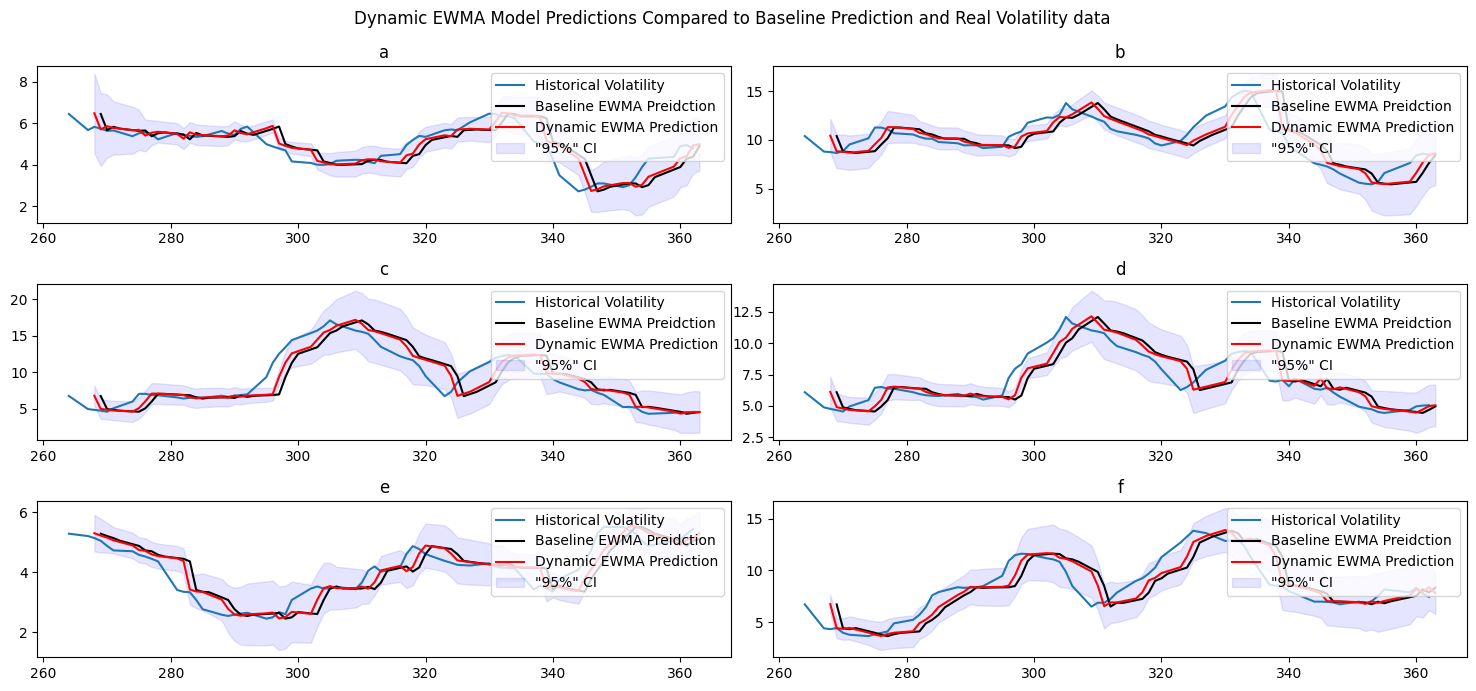

In [45]:
stocks_ = stocks
real_vol_ = real_vol[160:]
ewma_fits_ = ewma_fits[150:]
dynamic_ewma_pred_ = dynamic_ewma_pred[150:]
confint = confint.iloc[150:]
fig_ewma = lineplots_fitted(stocks_, real_vol_, label='Historical Volatility')
fig_ewma = lineplots_fitted(stocks_, ewma_fits_, fig=fig_ewma,color='black', label='Baseline EWMA Preidction')
fig_ewma = lineplots_fitted(stocks_, dynamic_ewma_pred_, fig=fig_ewma, title='Dynamic EWMA Model Predictions Compared to Baseline Prediction and Real Volatility data', color='red', label='Dynamic EWMA Prediction')
fig_ewma = confint_plots(stocks, dynamic_ewma_pred_.time, confint.lower, confint.upper, fig_ewma)

From above plots, we observe that the dynamic ewma model has predictions closer to the historical volatility, indicating that it has a reduced lag size compared to the baseline ewma model.

We also check if the weights used in the dynamic ewma model changes over time to ensure the model worked by plotting weights used for $MV_{t-1}, MV_{t-2}, MV_{t-3}$  to predict $MV_{t}$, $L \leq t \leq 363$. 

Text(0.5, 0.98, 'Dynamic EWMA Weights')

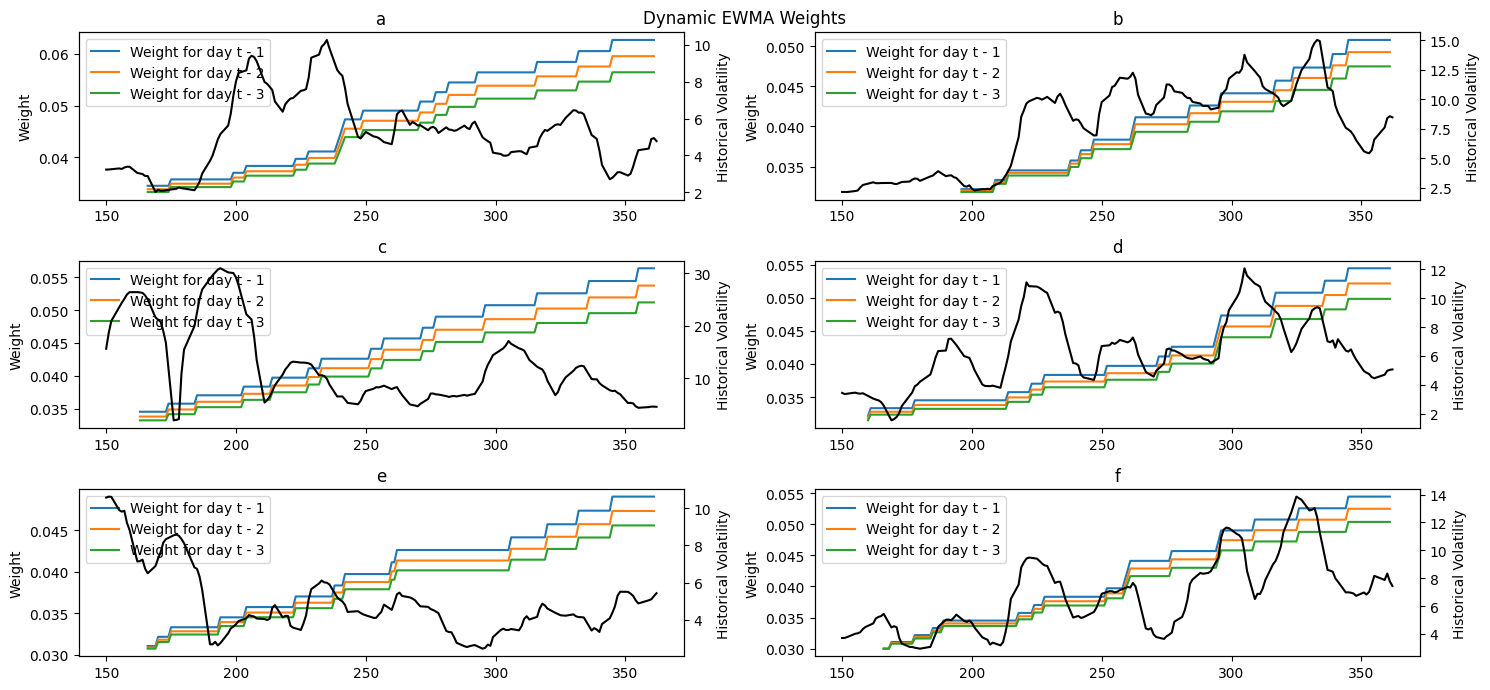

In [25]:
fig, axs = plt.subplots(3,2, figsize=(15,7))
for stock, ax in zip(stocks, axs.ravel()): 
    powers = powers_per_stock[stock]
    most_recent_powers = powers[powers.columns.values[:3]]
    ax.plot(most_recent_powers.index[stock_acf[stock]:-1] + 133, [alpha ** i for i in most_recent_powers.values[stock_acf[stock]:-1]], label=[f'Weight for day t - {day + 1}' for day in most_recent_powers.columns.values])
    ax.set_ylabel('Weight')
    twinax = ax.twinx()
    twinax.plot(monthly_vol[stock].loc[150:], label = 'historical volatility', color='black')
    twinax.set_ylabel('Historical Volatility')
    ax.legend()
    ax.title.set_text(stock)
fig.tight_layout()
fig.suptitle('Dynamic EWMA Weights')

Finally, from the weight plots, we notice following advantages & issues of the current model: 

**Advantages**
- Advantage 1: The model seem to reflect general movements in volatility.
- Advantage 2: From stock e and f's frequent change in weights, the model seems to have some advantage in volatility prediction while frequent volatility shift takes place. 

**Issues**
- Issue 1: Although the change in weights do follow the trend of volatility movements to some extent, in general, the scale of change in weights does not reflect the steepness of the change in volatility. This is well shown in stock e and f's plot, where there is a steep change in volatility while the weights for $MV_{t-1}, MV_{t-2}, MV_{t-3}$ are not distinctively different. 
- Issue 2: The lag between real volatility and predicted volatility still exists. For stock c, we previously observed that the volatility suffers two big abrupt. If such happens again, the model may fail to respond in a short period of time.  
- issue 3: Finally, notice the comparable size of standard deviation to the volatility prediction, indicating how the model has much room for improvement.

# Final Result

Finally, using the dynamic EWMA prediction model's result, we present the monthly volatility prediction and 1 standard deviation (68%) confidence intervals based on the past 22 day's standard deviation.

In [26]:
vol_predictions, sigmas = {}, {}
print("Monthly volatility prediction (in monthly percentage return)")
for stock in stocks: 
    ewma_stock = dynamic_ewma_pred[stock]
    sigma = np.round(ewma_stock.rolling(22).std().iloc[-1],2)
    vol_pred = np.round(ewma_stock.iloc[-1],2)
    print(f"stock {stock}: {vol_pred}%, 68% confidence interval: [{round(vol_pred - sigma,2)}%, {round(vol_pred + sigma,2)}%]")
    vol_predictions[stock] = vol_pred
    sigmas[stock] = sigma

monthly_vol.tail(5).T.loc[stocks]

Monthly volatility prediction (in monthly percentage return)
stock a: 4.94%, 68% confidence interval: [3.68%, 6.2%]
stock b: 8.57%, 68% confidence interval: [5.35%, 11.79%]
stock c: 4.57%, 68% confidence interval: [1.75%, 7.39%]
stock d: 5.03%, 68% confidence interval: [3.39%, 6.67%]
stock e: 5.27%, 68% confidence interval: [4.53%, 6.01%]
stock f: 7.79%, 68% confidence interval: [5.77%, 9.81%]


day,355,359,360,361,362
a,4.28593,4.37295,4.891132,4.941371,4.778997
b,6.601106,7.630356,8.418652,8.58174,8.483383
c,4.346145,4.479034,4.569704,4.567935,4.530611
d,4.447522,4.692188,4.965157,5.031033,5.057949
e,4.889347,5.056893,5.110751,5.282734,5.438152
f,8.16732,7.874605,8.33512,7.763291,7.439654


Such predictions also corresponds with the EDA on monthly volatility return. We crosscheck the predictions with the monthly volatility data of the last 5 days in the year and monthly volatility plot. We observe that
- Stock b's variance increases over time from the historical volatility plot, corresponding to highest standard deviation predicted compared to all other stocks.  
- Although c's volatility had some fluctuations of high width in the middle of the year, for the rest of the year had a rather consistent variance. This corresponds to smaller standard deviation prediction of stock c than stock b. 

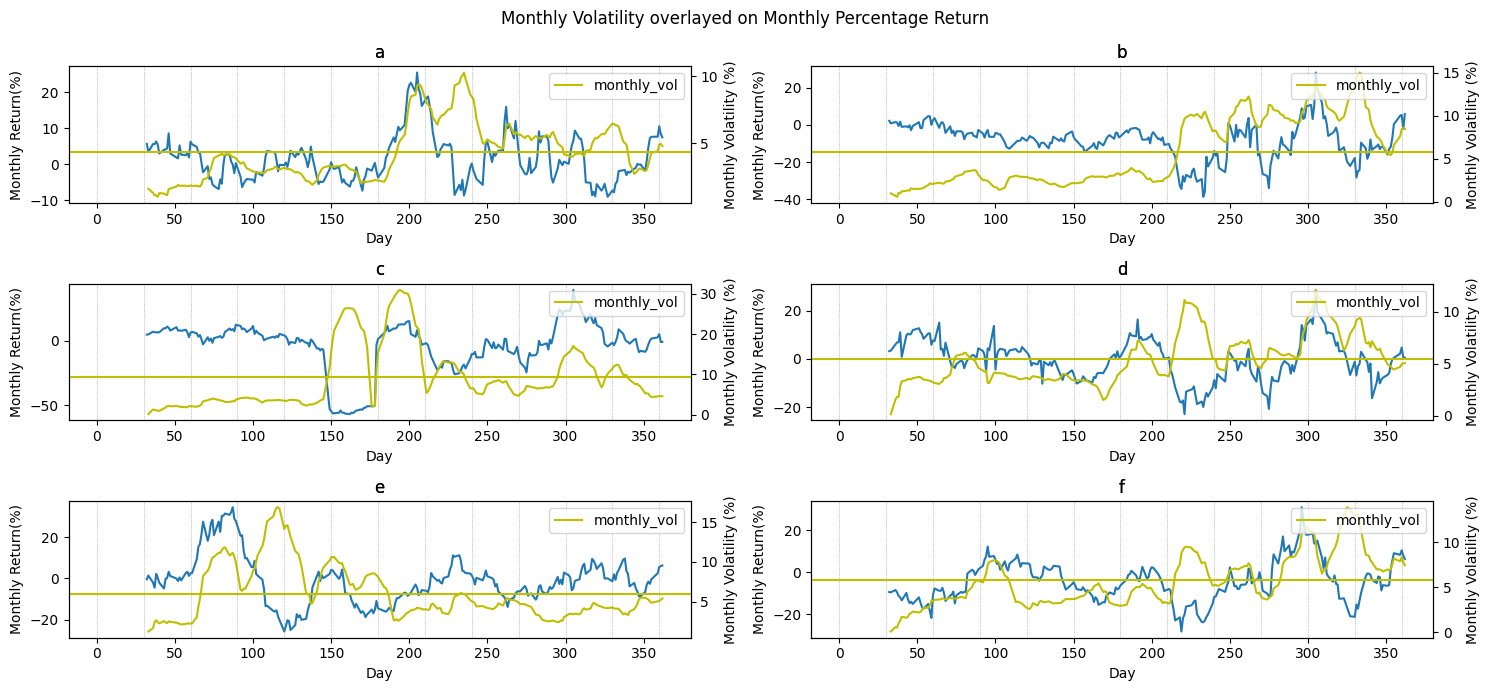

In [27]:
fig_3[0]

Finally, based on above, we compute the monthly volatility prediction for annualized percetange stock return by multiplying values with square root of 12. 

In [28]:
print("Monthly volatility prediction (in annualized percentage stock return per stock)")
for stock in stocks: 
    ewma_stock = dynamic_ewma_pred[stock]
    sigma = np.round(ewma_stock.rolling(22).std().iloc[-1],2)* math.sqrt(12)
    vol_pred = np.round(ewma_stock.iloc[-1],2) * math.sqrt(12)
    vol_predictions[stock] = vol_pred
    print(f"stock {stock}: {round(vol_pred,2)}%, 68% confidence interval: [{round(vol_pred - sigma,2)}%, {round(vol_pred + sigma,2)}%]")    
    sigmas[stock] = sigma

Monthly volatility prediction (in annualized percentage stock return per stock)
stock a: 17.11%, 68% confidence interval: [12.75%, 21.48%]
stock b: 29.69%, 68% confidence interval: [18.53%, 40.84%]
stock c: 15.83%, 68% confidence interval: [6.06%, 25.6%]
stock d: 17.42%, 68% confidence interval: [11.74%, 23.11%]
stock e: 18.26%, 68% confidence interval: [15.69%, 20.82%]
stock f: 26.99%, 68% confidence interval: [19.99%, 33.98%]


Note that the final predictions are made using the below parameters
- alpha = 0.03
- lookback $L$ = $[a: 11, b: 21, c: 10, d: 9, e: 11, f: 11]$
- weights for $MV_{t-k}$, $1 \leq k \leq L$ is as below.

In [29]:
weights = pd.DataFrame(index=range(max(stock_acf.values())))
for stock in stocks: 
    weights[stock] = pd.DataFrame([alpha ** i for i in powers_per_stock[stock].iloc[-1]])
weights.index = [f'day t -{i+1}' for i in range(21)]
weights = weights.T
display(weights)

,day t -1,day t -2,day t -3,day t -4,day t -5,day t -6,day t -7,day t -8,day t -9,day t -10,...,day t -12,day t -13,day t -14,day t -15,day t -16,day t -17,day t -18,day t -19,day t -20,day t -21
a,0.062651,0.059517,0.056412,0.052867,0.049614,0.046369,0.043462,0.040641,0.038126,0.036069,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b,0.050764,0.049245,0.047470,0.045487,0.043558,0.041639,0.039855,0.038171,0.036614,0.035262,...,0.033091,0.032314,0.031702,0.031258,0.030903,0.030628,0.030464,0.030401,0.030324,0.030242
c,0.056395,0.053754,0.051190,0.048245,0.045588,0.042956,0.040660,0.038466,0.036491,0.034874,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d,0.054452,0.052159,0.049834,0.047210,0.044868,0.042543,0.040400,0.038319,0.036428,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e,0.049014,0.047288,0.045555,0.043626,0.041876,0.040117,0.038503,0.036963,0.035584,0.034421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f,0.054452,0.052499,0.050384,0.048091,0.045897,0.043658,0.041531,0.039488,0.037621,0.036007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Bibliography
$[1]$ Dreyer, A., & Hubrich, S. (2017). Tail risk mitigation with managed volatility strategies. Dreyer, Anna and Hubrich, Stefan, Tail Risk Mitigation with Managed Volatility Strategies (April 16, 2019). Journal of Investment Strategies, 8(1), 29-56.

$[2]$ Bernard Bollen (2015) "What should the value of lambda be in the exponentially weighted moving average volatility model?", Applied Economics, 47:8, 853-860, DOI: 10.1080/00036846.2014.982853 (https://www.une.edu.au/__data/assets/pdf_file/0009/76464/unebsop14-1.pdf)

$[3]$ Gibbs, I., & Candes, E. (2021). Adaptive conformal inference under distribution shift. Advances in Neural Information Processing Systems, 34, 1660-1672.

# Appendix
1. Further explorations (1): Narrowing the confidence interval using Adaptive Conformal Inference

2. Further explorations (2): optimal alpha value --> multiple testing issue

3. Further exploration (3):  correlation matrix

## 1. Increasing the confidence interval coverage using Adaptive Conformal Inferenceptive 

Based on Gibbs' paper on Adaptive Conformal Inference to achieve long run alpha, we apply similar algorithm to increase the confidence inteval coverage in the long run.

------------------
$[3]$ Gibbs, I., & Candes, E. (2021). Adaptive conformal inference under distribution shift. Advances in Neural Information Processing Systems, 34, 1660-1672.

### ACI Using a Fixed Step Size

In [30]:
def compute_ewma_t(data, lbda, window):
    # note: does not include price_t in the computation of ewma_t
    numerator, denominator = 0, 0
    for i in range(window): # i is 0 to 32 
        numerator += (1 - lbda) ** i * data[window-1-i] #window = 33, so 32 to 0 
        denominator += (1 - lbda) ** i
    ewma_fit = numerator / denominator
    return ewma_fit

# parameter for confint tuning using aci
def adaptive_ewma_timeseries(stock, data, alpha, gamma, calibration_size, lbda=0.97):
    # note: calibration size must be bigger than lookback  
    # initialize variables
    lookback, alpha_t,stock_vol = stock_acf[stock], alpha, data[stock].values
    ewma_fits, conformity_scores, alphas, lower, upper =  [], [], [], [], []
        
    ## caliberate alpha_t using calibration set
    # compute initial fits, initial sigma & initial conformity score using calibration set 
    for t in range(lookback+1, lookback + calibration_size+1): 
        ## ex. acf = 33, lookback 30, start calculating scores from day 33 (data starts at day 0) to day 63 using past 33 days from each day 
        ewma_fit_t = compute_ewma_t(stock_vol[t-lookback-1:t-1], lbda=lbda, window=lookback) # want to use data from day 0 to 32 
        ewma_fits.append(ewma_fit_t)
        sigma_t = np.std(ewma_fits)
        conformity_score_t = abs(ewma_fit_t - stock_vol[t]) / (sigma_t**2) # division by sigma^2 to adjust to the nonzero (confirmed from plots) and non-constant variance 
        conformity_scores.append(conformity_score_t)

    t = lookback + calibration_size
    # print(len(ewma_fits), len(conformity_scores), t, len(conformity_scores[t-lookback-20: t-lookback])) ## t = 63, [43:63]

    # compute initial confidence interval of y_t 
    past_scores_within_month = conformity_scores[t-lookback-20: t-lookback] 
    y_t_pred = ewma_fits[-1]
    sigma = np.quantile(past_scores_within_month, 1-alpha_t)
    confint_t = [max(np.round(y_t_pred - 1.96 * sigma, 2), 0), np.round(y_t_pred + 1.96 * sigma, 2)]
    lower.append(confint_t[0])
    upper.append(confint_t[1])

    # check if y_t is within the confidence interval
    error_t = 1 if (stock_vol[t] < confint_t[0]) or (stock_vol[t]  > confint_t[1]) else -1
    # print(error_t, stock_vol[t], confint_t, y_t_pred)

    ## adaptive part 
    for t in range(lookback + calibration_size+1, len(stock_vol)):
        ## update alpha_t
        # if error_t: print(error_t)
        alpha_t = alpha_t + error_t * gamma
        alphas.append(alpha_t)

        ## compute ewma_t
        ewma_fit_t = compute_ewma_t(stock_vol[t-lookback-1:t-1], lbda=lbda, window=lookback)
        ewma_fits.append(ewma_fit_t)
        sigma_t = np.std(ewma_fits)
        score_t = abs(ewma_fit_t - stock_data[t]) / (sigma_t**2)
        conformity_scores.append(score_t)
        # print(len(conformity_scores))

        ## compute confidence interval
        past_scores_within_month = conformity_scores[t-lookback-20: t-lookback]
        
        sigma = np.quantile(past_scores_within_month, 1-alpha_t)
        # print(sigma)

        confint_t = [max(np.round(ewma_fit_t - 1.96 * sigma_t, 2), 0), np.round(ewma_fit_t + 1.96 * sigma_t, 2)]

        ## check if y_t is within the confidence interval
        error_t = 1 if (stock_vol[t] < confint_t[0]) or (stock_vol[t]  > confint_t[1]) else -1
        # print(t, alpha_t)
        lower.append(confint_t[0])
        upper.append(confint_t[1])
        
        # print(error_t, stock_data[t], confint_t, y_t_pred)
    return ewma_fits, alphas, lower, upper

RMSE Base : {'a': 0.7702484986437987, 'b': 1.2055691714405659, 'c': 3.725109278959404, 'd': 1.0855813866315114, 'e': 1.3616099645670416, 'f': 1.1893010001307915}
RMSE Dynamic EMWA: {'a': 0.597754420820564, 'b': 0.9543112985533236, 'c': 3.0424609746698223, 'd': 0.8384203492861063, 'e': 1.0753073132410806, 'f': 0.9475298876759992}
RMSE ACI : {'a': 0.5951294165182374, 'b': 0.9513493206633357, 'c': 3.0342906649143053, 'd': 0.8360276988067665, 'e': 1.0743673429066691, 'f': 0.9438133725752642}
stock a: confidence interval coverage 24.35%
stock b: confidence interval coverage 22.17%
stock c: confidence interval coverage 25.22%
stock d: confidence interval coverage 23.48%
stock e: confidence interval coverage 23.48%
stock f: confidence interval coverage 24.78%


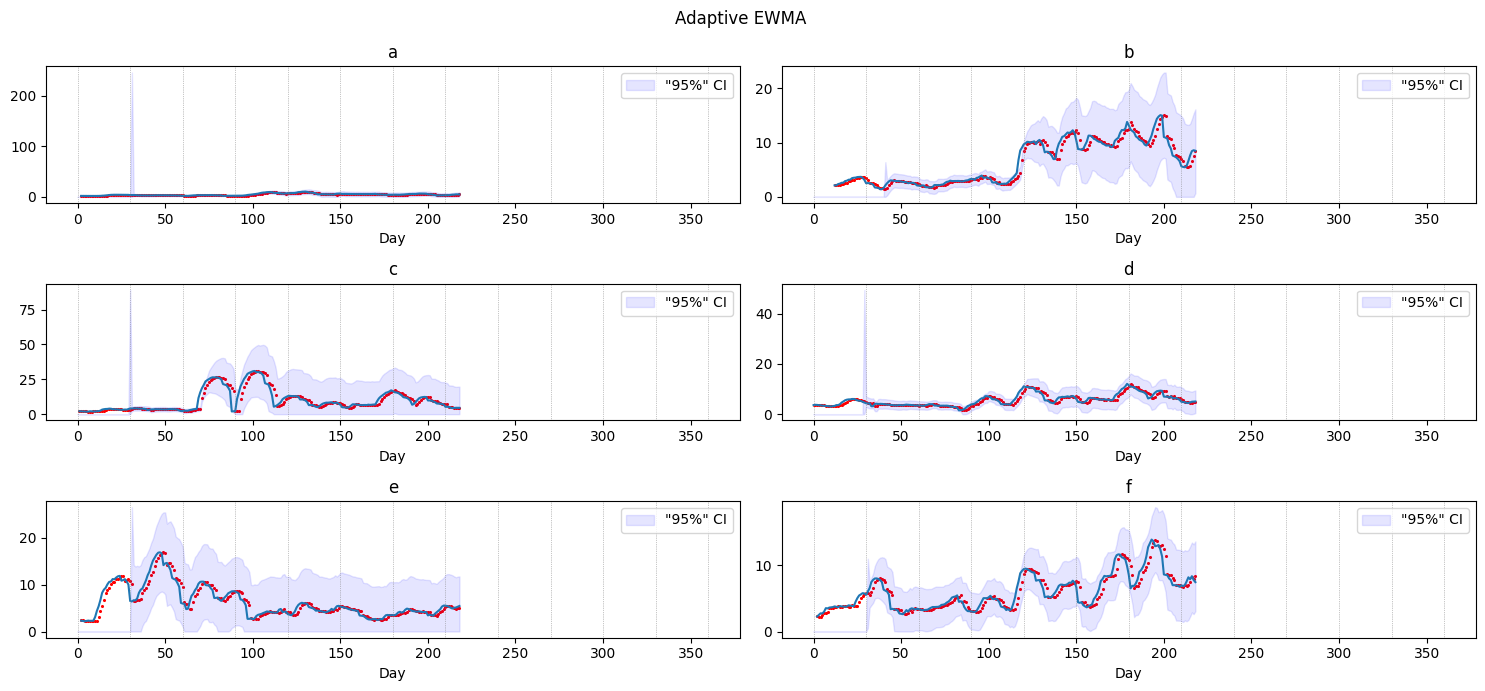

In [31]:
# ewma with adjusted confidence interval 
# want to integrate all points as I go, no "outliers" as we do not have enough data 
predictions, real_vols, lower, upper = {}, {}, {}, {}
for stock in stocks: 
    simulation = adaptive_ewma_timeseries(stock, monthly_vol, alpha=0.05, gamma=0.00001, calibration_size=30)
    real_vol = monthly_vol[stock].iloc[stock_acf[stock]+1:]
    predictions[stock],lower[stock], upper[stock] = simulation[0],[0] * 29 + simulation[2], [0] * 29 + simulation[3]
    real_vols[stock] = real_vol

predictions, real_vols, lower, upper = dict_to_df(predictions), dict_to_df(real_vols,True), dict_to_df(lower,True), dict_to_df(upper,True)
upper.replace(np.nan, 0, inplace=True)
lower.replace(np.nan, 0, inplace=True)
# fig_ewma = lineplots(stocks, monthly_vol, title='Historical Price')
# fig_ewma = scatterplots(stocks, ewma_stocks, fig=fig_ewma, title='EWMA', color='red')
fig_simulation = lineplots(stocks, real_vols, title='Historical Price')
fig_simulation = scatterplots(stocks, predictions, fig=fig_simulation, title='Adaptive EWMA', color='red')  
fig_simulation = confint_plots(stocks, predictions.time, lower, upper, fig=fig_simulation)

rmse_aci = rmse(stocks, real_vols, predictions)
print(f"RMSE Base : {rmse_base}")
print(f"RMSE Dynamic EMWA: {rmse_dynamic}")
print(f"RMSE ACI : {rmse_aci}")

for stock in stocks: 
    coverage = np.mean((monthly_vol[stock] - confint.lower[stock]) * (confint.upper[stock] - monthly_vol[stock]) > 0) * 100 ## need to drop zero parts
    print(f"stock {stock}: confidence interval coverage {np.round(coverage, 2)}%")
## notice same prediction accuracy (fix this, bc of lookback period) but decreased confindence interval error rate (but it's because it is wider? )

### ACI Using an Adaptive Step Size

In [32]:
## based on ACF
def compute_tuned_ewma_t(data, lbda, window, prev_acfs):
    # note: does not include price_t in the computation of ewma_t
    numerator, denominator, acf = 0, 0, []
    for i in range(window): # i is 0 to 32 
        # calculate autocorrelation 
        if len(prev_acfs): 
            acf = pd.Series(data).autocorr(lag=i)
            acf[i] = acf

        # if correlation is higher than before, tune the params by lowering the i value 
        if len(prev_acfs) and acf > prev_acfs[i]: 
            tuned_i = i * 0.99
        else: 
            tuned_i = i * 1.01

        numerator += (1 - lbda) ** tuned_i * data[window-1-i] #window = 33, so 32 to 0 
        denominator += (1 - lbda) ** i
    ewma_fit = numerator / denominator
    return ewma_fit, acf

# parameter for confint tuning using aci
def adaptive_tuned_ewma_timeseries(stock, data, alpha, gamma, calibration_size, lbda=0.97):
    # note: calibration size must be bigger than lookback  
    # initialize variables
    lookback, alpha_t,stock_vol = stock_acf[stock], alpha, data[stock].values
    ewma_fits, conformity_scores, alphas, sigmas, acfs =  [], [], [], [], []
    
    ## caliberate alpha_t using calibration set
    # compute initial fits, initial sigma & initial conformity score using calibration set 
    for t in range(lookback+1, lookback + calibration_size+1): 
        ## ex. acf = 33, lookback 30, start calculating scores from day 33 (data starts at day 0) to day 63 using past 33 days from each day 
        ewma_fit_t, acfs = compute_tuned_ewma_t(stock_vol[t-lookback-1:t-1], lbda=lbda, window=lookback, prev_acfs=acfs) # want to use data from day 0 to 32 
        ewma_fits.append(ewma_fit_t)
        sigma_t = np.std(ewma_fits) 
        ## ?? how am I deciding the size of the window for sigma_t? 
        conformity_score_t = abs(ewma_fit_t - stock_vol[t]) # / (sigma_t**2) # division by sigma^2 to adjust to the nonzero (confirmed from plots) and non-constant variance 
        conformity_scores.append(conformity_score_t)

    t = lookback + calibration_size
    # print(len(ewma_fits), len(conformity_scores), t, len(conformity_scores[t-lookback-20: t-lookback])) ## t = 63, [43:63]

    # compute initial confidence interval of y_t 
    past_scores_within_month = conformity_scores[t-lookback-20: t-lookback] ## -20 working days? or lookback? since I am trying to find a monthly volatility, should be 20 days I think .. 
    y_t_pred = ewma_fits[-1]
    sigma = np.quantile(past_scores_within_month, 1-alpha_t)
    sigmas.append(sigma)
    confint_t = [max(np.round(y_t_pred - 1.96 * sigma, 2), 0), np.round(y_t_pred + 1.96 * sigma, 2)]

    # check if y_t is within the confidence interval
    error_t = 1 if (stock_vol[t] < confint_t[0]) or (stock_vol[t]  > confint_t[1]) else -1
    # print(error_t, stock_vol[t], confint_t, y_t_pred)

    ## adaptive part 
    for t in range(lookback + calibration_size+1, len(stock_vol)):
        ## update alpha_t
        # if error_t: print(error_t)
        alpha_t = alpha_t + error_t * gamma
        alphas.append(alpha_t)

        ## compute ewma_t
        ewma_fit_t, acfs = compute_tuned_ewma_t(stock_vol[t-lookback-1:t-1], lbda=lbda, window=lookback, prev_acfs=acfs)
        ewma_fits.append(ewma_fit_t)
        sigma_t = np.std(ewma_fits)
        score_t = abs(ewma_fit_t - stock_data[t]) #/ (sigma_t**2)
        conformity_scores.append(score_t)
        # print(len(conformity_scores))

        ## compute confidence interval
        past_scores_within_month = conformity_scores[t-lookback-20: t-lookback]
        
        sigma = np.quantile(past_scores_within_month, 1-alpha_t)
        # except: print(past_scores_within_month)

        confint_t = [max(np.round(ewma_fit_t - 1.96 * sigma, 2), 0), np.round(ewma_fit_t + 1.96 * sigma, 2)]

        ## check if y_t is within the confidence interval
        error_t = 1 if (stock_vol[t] < confint_t[0]) or (stock_vol[t]  > confint_t[1]) else -1
        # print(t, alpha_t)
        sigmas.append(sigma)
        
        
        # print(error_t, stock_data[t], confint_t, y_t_pred)
    return ewma_fits, alphas, sigmas, conformity_scores

rmse base : {'a': 0.7702484986437987, 'b': 1.2055691714405659, 'c': 3.725109278959404, 'd': 1.0855813866315114, 'e': 1.3616099645670416, 'f': 1.1893010001307915}
rmse aci : {'a': 0.5951294165182374, 'b': 0.9513493206633357, 'c': 3.0342906649143053, 'd': 0.8360276988067665, 'e': 1.0743673429066691, 'f': 0.9438133725752642}
rmse tuned aci : {'a': 0.5996467825763153, 'b': 0.9582891827167473, 'c': 3.0555473931450803, 'd': 0.8420747119336285, 'e': 1.0818527511308198, 'f': 0.9513854404182381}


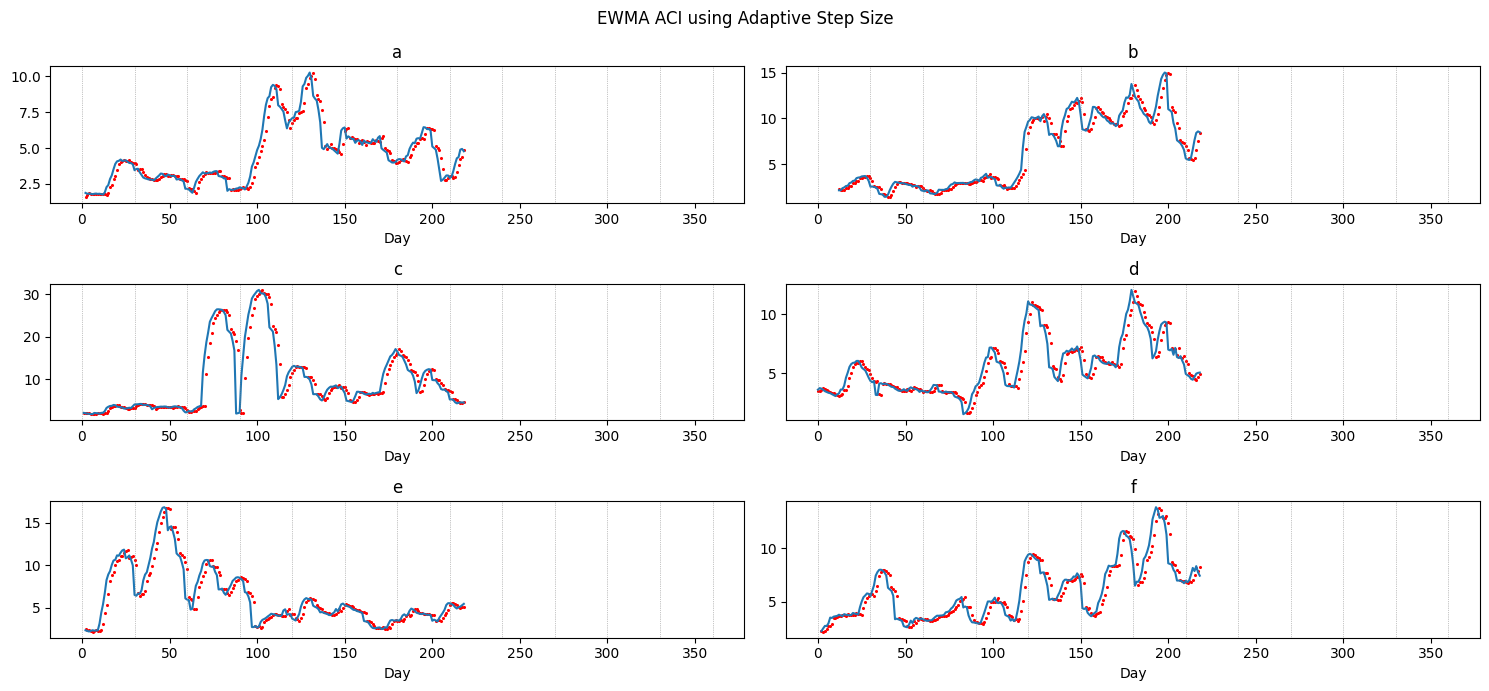

In [33]:
simulations, real_vols = {}, {}
for stock in stocks: 
    simulation = adaptive_tuned_ewma_timeseries(stock, monthly_vol, alpha=0.05, lbda = 0.94, gamma=0.0001, calibration_size=30)
    real_vol = monthly_vol[stock].iloc[stock_acf[stock]+1:]
    simulations[stock] = simulation[0]
    real_vols[stock] = real_vol

max_len_sim = max(len(lst) for lst in simulations.values())
max_len_real = max(len(lst) for lst in real_vols.values())
simulations = {k: ([np.nan] * (max_len_sim - len(v))) + v for k, v in simulations.items()}
real_vols = {k: ([np.nan] * (max_len_real - len(v))) + list(v) for k, v in real_vols.items()}
simulations = pd.DataFrame(simulations)
real_vols = pd.DataFrame(real_vols)
real_vols['time'] = real_vols.index
simulations['time'] = simulations.index

fig_simulation = lineplots(stocks, real_vols, title='Historical Price')
fig_simulation = scatterplots(stocks, simulations, fig=fig_simulation, title='EWMA ACI using Adaptive Step Size', color='red')    
mse_tuned_aci = rmse(stocks, real_vols, simulations)
print(f"rmse base : {rmse_base}")
print(f"rmse aci : {rmse_aci}")
print(f"rmse tuned aci : {mse_tuned_aci}")

## 2. Parameter Tuning: finding the optimal alpha

100%|██████████| 49/49 [00:06<00:00,  7.66it/s]


stock a min rmse: 0.5931984236489748 at alpha 0.01
stock b min rmse: 0.9478805764650057 at alpha 0.01
stock c min rmse: 3.0219013031109228 at alpha 0.01
stock d min rmse: 0.8327126654818485 at alpha 0.01
stock e min rmse: 1.0693749334966596 at alpha 0.01
stock f min rmse: 0.9402361066278069 at alpha 0.01


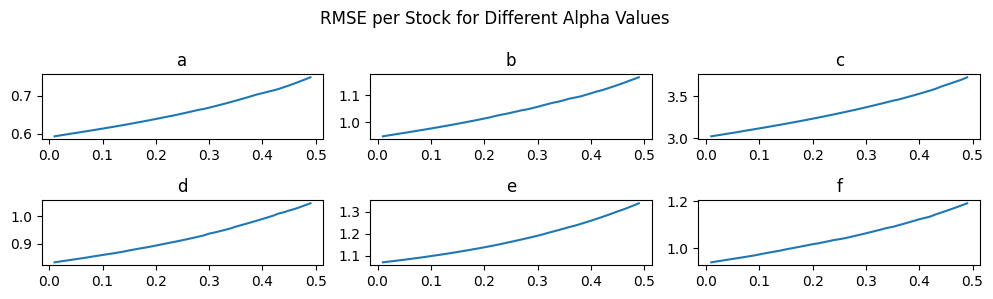

In [34]:
rmse_per_alpha = {}
for alpha in tqdm(range(1, 50)): 
    alpha, ewma_stocks, stock_list = alpha/100, pd.DataFrame(), 'c a b d e f'.split(" ")
    dynamic_ewma_pred, real_vol, powers_per_stock, rmse_dynamic =  compute_dynamic_ewma_stocks(stocks, monthly_vol, stock_acf, alpha)
    rmse_per_alpha[alpha] = rmse_dynamic

optimal_alphas = {}
fig, axs = plt.subplots(2,3, figsize=(10,3)) 
for stock, ax in zip(stocks, axs.ravel()):
    stock_rmse = [v[stock] for v in rmse_per_alpha.values()]
    optimal_alpha = min(rmse_per_alpha, key=lambda x: rmse_per_alpha[x][stock])
    optimal_alphas[stock] = optimal_alpha
    print(f'stock {stock} min rmse: {min(stock_rmse)} at alpha {optimal_alpha}')
    ax.plot(rmse_per_alpha.keys(), stock_rmse)
    ax.set_title(stock)

fig.suptitle('RMSE per Stock for Different Alpha Values')
fig.tight_layout()

## 3. Stock Correlation Heatmap

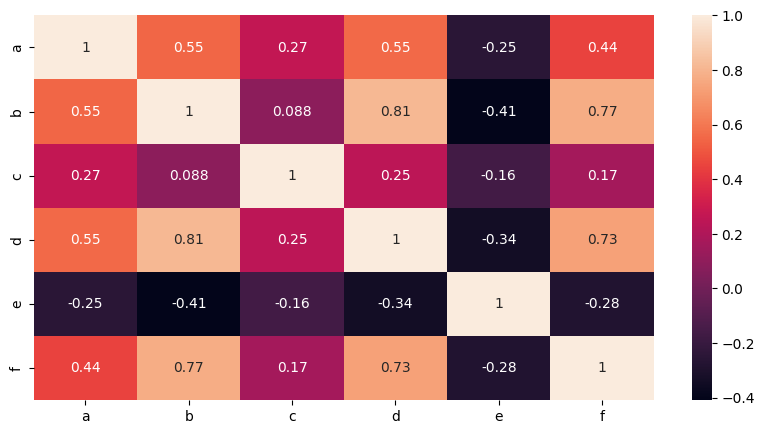

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
corr = monthly_vol[stocks].corr()
sns.heatmap(corr, annot=True)
similar_stocks = 'b d b f e b'.split(" ")